<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [55]:
data = pd.read_csv('./train.csv')

In [56]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

- Мы видим, что признак 'TotalSpent' иммет тип object , хотя является float. Нужно поменять. Однако это происходит потому, что тем есть пропущенные значения в виде пробела, т.е. " ".


In [73]:
data.loc[data['TotalSpent'] == ' '] = np.nan # сначала переделаем их в НаН
data['TotalSpent'] = data['TotalSpent'].astype(float) # Поменяем тип
data.loc[data['TotalSpent'].isnull(), 'TotalSpent'] = data['TotalSpent'].mean() # Заменим пропущенные на среднюю

In [76]:
data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.846090,2287.486161,0.159409,0.262022
std,24.550326,30.270989,2269.049195,0.366092,0.439776
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,35.400000,395.725000,0.000000,0.000000
50%,29.000000,70.400000,1405.650000,0.000000,0.000000
75%,55.000000,90.050000,3795.212500,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


- Данные без Выбросов

In [7]:
data.head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


<AxesSubplot:>

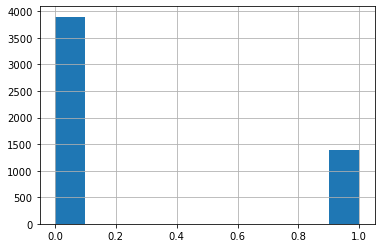

In [15]:
data['Churn'].hist()

In [16]:
data['Churn'].value_counts(normalize=True)

0    0.737978
1    0.262022
Name: Churn, dtype: float64

- Целевая переменная имеет дисбаланс, но не очень сильный. В конце можно по эксперементировать с андерсемплингом. 

#### По описательной статистике, мы видели, что на первый взгляд непрерывные признаки не имеют выбросов, для наглядности можем построить боксплоты и убедиться.

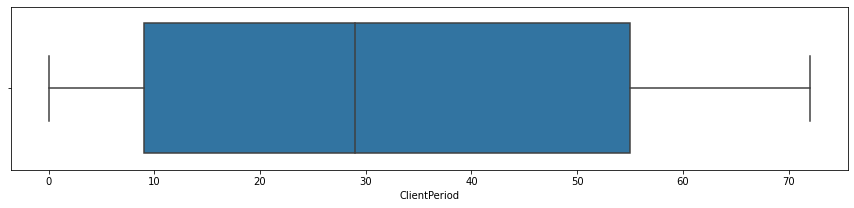

In [37]:
plt.figure(figsize=(15,3))
sns.boxplot(data['ClientPeriod']);

- Как мы видим выбросов нет. Посмотрим  на распределение целевой переменной в разрезе 'ClientPeriod'.

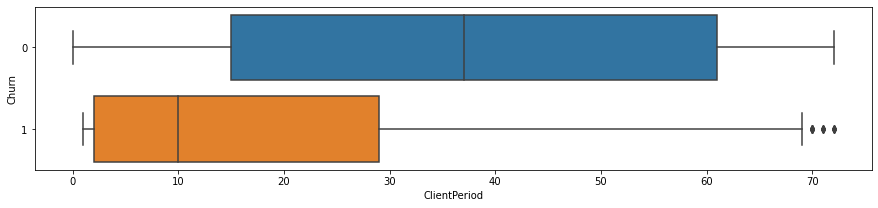

In [39]:
plt.figure(figsize=(15,3))
sns.boxplot(x='ClientPeriod', y='Churn', data=data[['ClientPeriod', 'Churn']], orient='h');

- Как мы видим распределение явно отличается, среднее 1 класса по этому признаку смещено ближе к 0. 

''

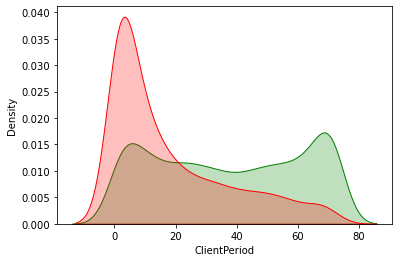

In [46]:
churn_spread = data[['ClientPeriod', 'Churn']]
churn_1 = churn_spread.loc[churn_spread['Churn'] == 1, 'ClientPeriod']
churn_0 = churn_spread.loc[churn_spread['Churn'] == 0, 'ClientPeriod']
sns.kdeplot(churn_0, shade=True,  color='g')
sns.kdeplot(churn_1, shade=True,  color='r')
;

- Исходя из наблюдений, можно сделать вывод, что люди на много чаще уходят при ClientPeriod (т.к. нет описания призноков, будем считать, что это время, которое человек провел пользуясь услугами.) близким к 0. Можно интерпритировать это, как то, что человек принимает решение,  о том, нравится ему компания или нет в первые дни. Как рекомендация, в период 0 - 20 предоставлять доп скидки.

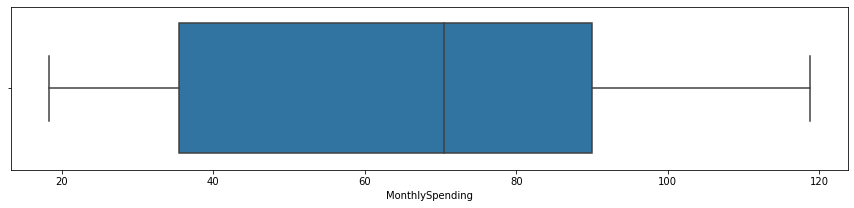

In [41]:
plt.figure(figsize=(15,3))
sns.boxplot(data['MonthlySpending']);

- Как мы видим выбросов нет. Посмотрим  на распределение целевой переменной в разрезе 'ClientPeriod'.

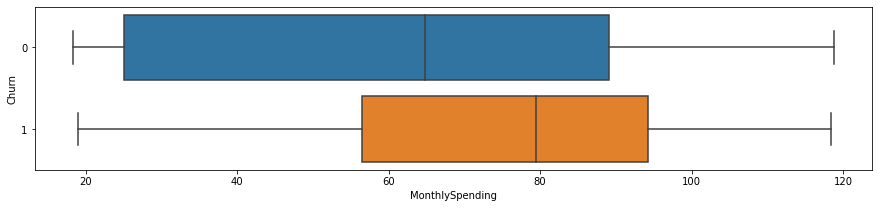

In [42]:
plt.figure(figsize=(15,3))
sns.boxplot(x='MonthlySpending', y='Churn', data=data[['MonthlySpending', 'Churn']], orient='h');

- В целом распределение похоже, хотя средние также смещены. Посмотрим на плотность.

<AxesSubplot:xlabel='MonthlySpending', ylabel='Density'>

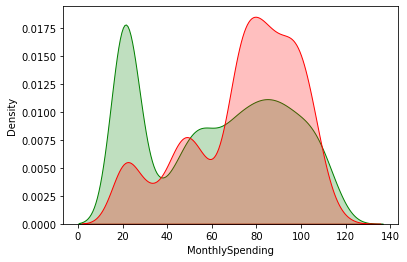

In [44]:
churn_spread = data[['MonthlySpending', 'Churn']]
churn_1 = churn_spread.loc[churn_spread['Churn'] == 1, 'MonthlySpending']
churn_0 = churn_spread.loc[churn_spread['Churn'] == 0, 'MonthlySpending']
sns.kdeplot(churn_0, shade=True,  color='g')
sns.kdeplot(churn_1, shade=True,  color='r')

- Видна прямая зависимость количества ушедших от ежемесячного расхода.

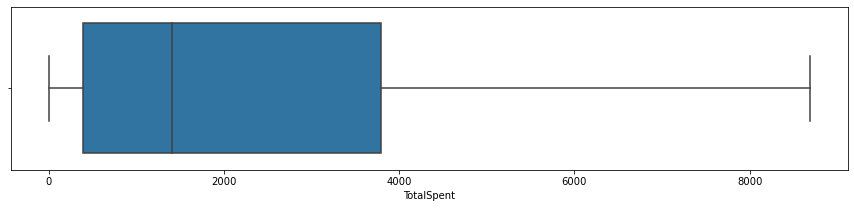

In [77]:
plt.figure(figsize=(15,3))
sns.boxplot(data['TotalSpent']);

- Выбросов нет.

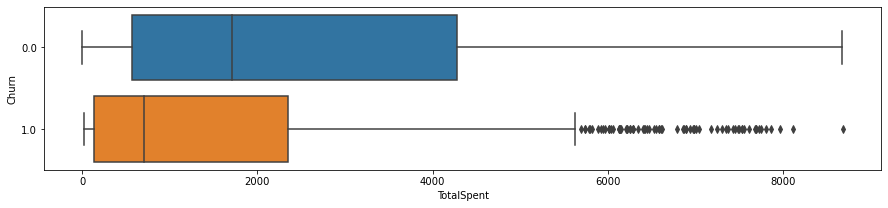

In [78]:
plt.figure(figsize=(15,3))
sns.boxplot(x='TotalSpent', y='Churn', data=data[['TotalSpent', 'Churn']], orient='h');

<AxesSubplot:xlabel='TotalSpent', ylabel='Density'>

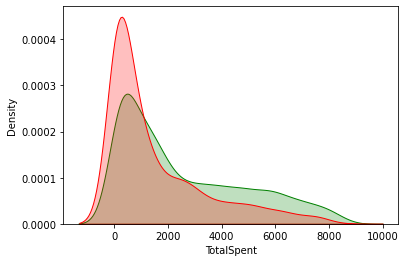

In [79]:
churn_spread = data[['TotalSpent', 'Churn']]
churn_1 = churn_spread.loc[churn_spread['Churn'] == 1, 'TotalSpent']
churn_0 = churn_spread.loc[churn_spread['Churn'] == 0, 'TotalSpent']
sns.kdeplot(churn_0, shade=True,  color='g')
sns.kdeplot(churn_1, shade=True,  color='r')

- Хоть средняя смещена, но не вижу выдающейся разницы, как на предыдущих признаках. Скорее всего признак будет иметь малый вес.  

In [82]:
cols_for_pair = ['ClientPeriod','MonthlySpending', 'TotalSpent', 'Churn']

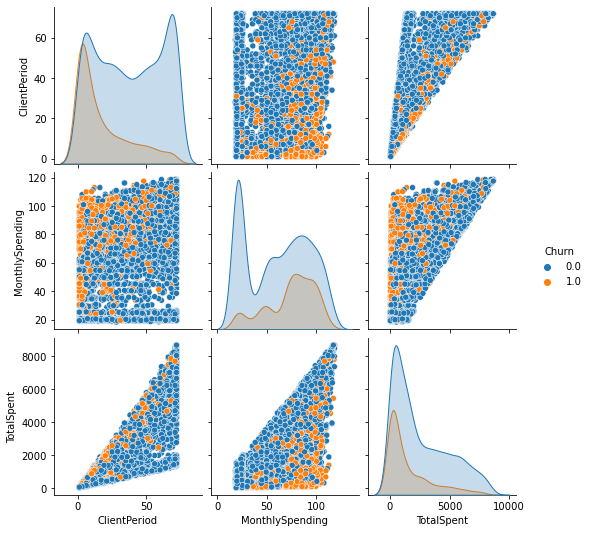

In [110]:
sns.pairplot(data=data[cols_for_pair], hue='Churn')

- Стоит обратить внимание, на большое скопление ушедших на пересечении больших месячных расходов и малого "клиентского периода".
- Также видно аномальки в виде "0"

#### Посмотри категориальные признаки

In [89]:
for cat in cat_cols:
    print(data[cat].value_counts())

Male      2651
Female    2622
0            9
Name: Sex, dtype: int64
0.0    4440
1.0     842
Name: IsSeniorCitizen, dtype: int64
No     2704
Yes    2569
0         9
Name: HasPartner, dtype: int64
No     3676
Yes    1597
0         9
Name: HasChild, dtype: int64
Yes    4754
No      519
0         9
Name: HasPhoneService, dtype: int64
No                  2508
Yes                 2246
No phone service     519
0                      9
Name: HasMultiplePhoneNumbers, dtype: int64
Fiber optic    2341
DSL            1795
No             1137
0                 9
Name: HasInternetService, dtype: int64
No                     2611
Yes                    1525
No internet service    1137
0                         9
Name: HasOnlineSecurityService, dtype: int64
No                     2331
Yes                    1805
No internet service    1137
0                         9
Name: HasOnlineBackup, dtype: int64
No                     2316
Yes                    1820
No internet service    1137
0              

- Мы видим, что в данных есть "0" подозреваю, что это затаившиеся NAN. Их по 9 шт, по этому можно просто удалить эти строки.

In [107]:
data.loc[data['Sex'] == 0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1707,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2543,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3078,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3697,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4002,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4326,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4551,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4598,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


- Видно, что есть строки просто с 0 во всех значениях. Удалим их.

In [108]:
data = data.loc[data['Sex'] != 0]

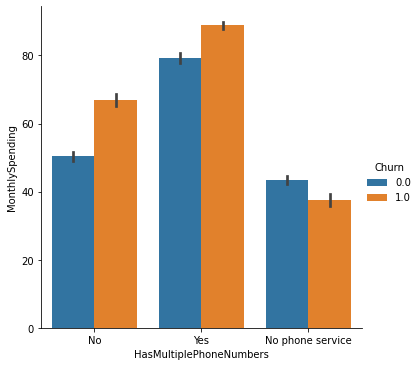

In [109]:
sns.catplot(y='MonthlySpending',
            x='HasMultiplePhoneNumbers',
            hue='Churn',
            kind='bar',
            data=data);

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
# YOUR CODE

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [ ]:
# YOUR CODE

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [ ]:
best_model = # какая-то предыдущая модель

SyntaxError: invalid syntax (<ipython-input-12-7d881febecc7>, line 1)

In [ ]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = # best_model.predict_proba(X_test) / best_model.predict(X_test)
submission.to_csv('./my_submission.csv')

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.